In [1]:
import rankedDelegation as rd
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import pulp
import time
from IPython.utils import io
np.random.seed(42)

# Load the data

In [2]:
path = "C:\\Users\\Theo Delemazure\\Documents\\ENS\\Stage Berlin\\data\\"
list_datasets = [{"path":"bitcoin\\out.soc-sign-bitcoinalpha","name":"Bitcoin Alpha"}, 
                {"path":"bitcoin\\out.soc-sign-bitcoinotc","name":"Bitcoin OTC"}]
def load_data(index):
    full_path = path + list_datasets[index]["path"]
    list_edges = np.genfromtxt(full_path, delimiter="\t",dtype=int)[:,:3]
    nb_nodes= int(np.max(list_edges))+1
    list_nodes = np.arange(nb_nodes)
    count_out = np.zeros(nb_nodes)
    count_in = np.zeros(nb_nodes)

    for (a, b, _) in tqdm(list_edges):
        if a != b:
            count_out[a] += 1
            count_in[b] += 1
    
    return {"edges":list_edges,"out": count_out, "in": count_in, "nb_nodes": nb_nodes}

In [3]:
def create_election(data, p=0.8):
    n = data["nb_nodes"]
    list_edges = data["edges"]
    
    e = rd.Election()
    outedges_dict = {}
    for (a, b, score) in tqdm(list_edges):
        if score <= 0:
            continue
        if a not in outedges_dict:
            outedges_dict[a] = [[] for i in range(11)]
        outedges_dict[a][score].append(b)
    
    # Add casting voters
    for i in tqdm(range(n)):
        x = np.random.choice([0,1,2],p=[p,(1-p)/2,(1-p)/2])
        if x == 0:
            v = rd.Voter()
        else:
            v = rd.Voter(vote=x)
        e.add_voter(v)

    # Add edges
    L = e.list_voters
    delegatees_list = [[] for i in range(n)]
    n_edges = 0
    
    for r_1 in tqdm(range(n)):
        if L[r_1].vote is not None or r_1 not in outedges_dict:
            continue
            
        ordering = []
        for i in range(10, 0, -1):
            tab = outedges_dict[r_1][i]
            np.random.shuffle(tab)
            for x in tab:
                ordering.append(x)
        
        for ind in ordering:
            delegatees_list[r_1].append(L[ind])
            
    for voter in L:
        voter.delegate(delegatees_list[voter.id])
    
    return e


In [4]:
def save_election(e, results, title=""):
    L = []
    C = []
    timestamp = int(time.time())
    for v in tqdm(e.list_voters):
        for i, d in enumerate(v.delegatees):
            L.append((v.id, d.id, i+1))
        if v.vote is not None:
            C.append((v.id, 1))
        else:
            C.append((v.id, 0))
        
    np.savetxt("Save/edges_%s_%i.csv"%(title,timestamp), L)
    np.savetxt("Save/nodes_%s_%i.csv"%(title,timestamp), C)
    results.to_csv("Save/results_%s_%i.csv"%(title, timestamp))

In [5]:
def print_results(e):
    print("Winner is %i"%e.winner)
    print("Results : ",e.results)
    c_gurus = 0
    for v in e.list_voters:
        if v.vote is not None:
            c_gurus += 1
    s = np.log(c_gurus)
    
    print("Maximum rank is %i"%e.max_rank)
    print("Maximum length is %i"%e.max_length)
    print("Average length is %.2f"%e.mean_length)
    print("Maximum guru power is %i"%e.max_power)
    print("Entropy guru power is %.2f (best : %.2f)"%(e.power_entropy, s))
    print("Maximum sum of rank is %i"%e.max_sum)
    print("Sum of rank is %i (only for confluent rules)"%e.sum_rank)
    print("Avg rank is %.2f (only for confluent rules)"%e.avg_rank)
    plt.figure(figsize=(15,5))
    plt.hist(e.list_powers,bins=1000)
    plt.xlim(1,10000)
    plt.xscale("log")
    plt.yscale("log")
    plt.title("Guru distribution of power")
    plt.xlabel("Power")
    plt.ylabel("Number of nodes")
    plt.show()
    #print("Unpopularity is %i (only for confluent rules)"%e.unpopularity)

# Try rules

In [8]:
def run_election(index):
    data= load_data(index)

    rules = [rd.rules.naive_BFD, rd.rules.minsum, rd.rules.naive_DFD, 
             rd.rules.diffusion, rd.rules.lexrank, rd.rules.minSumRank]

    rules_str = ["BFD", "MinSumPath", "DFD","Diffusion", "LexRank","MinArb"]

    metrics_str = ["Max Rank", "Max Length", "Avg Length","Max Power", "Max representation",
                "Power entropy", "Max Sum", "Sum of Rank", "Avg Rank", "Unpopularity"]

    seed = np.random.randint(100000)
    print(seed)
    np.random.seed(seed)
    n_rules = len(rules)
    tab_results = np.zeros((10, n_rules))
    e = create_election(data)

    for i, rule in tqdm(enumerate(rules)):
        e.attribute_gurus(rule)
        tab_results[0, i] += e.max_rank
        tab_results[1, i] += e.max_length
        tab_results[2, i] += e.mean_length
        tab_results[3, i] += e.max_power
        tab_results[4, i] += e.max_representation
        tab_results[5, i] += e.power_entropy
        tab_results[6, i] += e.max_sum
        tab_results[7, i] += e.sum_rank
        tab_results[8, i] += e.avg_rank
        tab_results[9, i] += e.unpopularity

    df = pd.DataFrame(tab_results.T, index=rules_str, columns=metrics_str)
    save_election(e, df, list_datasets[index]["name"])

for _ in range(10):
    run_election(0)

  0%|          | 0/3784 [00:00<?, ?it/s]

73893


100%|██████████| 3784/3784 [00:00<00:00, 84312.10it/s]
6it [01:14, 12.47s/it]
 44%|████▍     | 1674/3784 [00:00<00:00, 16624.48it/s]

45581


100%|██████████| 3784/3784 [00:00<00:00, 108526.54it/s]
6it [01:11, 11.94s/it]
  0%|          | 0/3784 [00:00<?, ?it/s]

74592


100%|██████████| 3784/3784 [00:00<00:00, 122390.60it/s]
6it [01:43, 17.32s/it]
  0%|          | 0/3784 [00:00<?, ?it/s]

68423


100%|██████████| 3784/3784 [00:00<00:00, 77437.33it/s]
6it [01:51, 18.51s/it]
  0%|          | 0/3784 [00:00<?, ?it/s]

45926


100%|██████████| 3784/3784 [00:00<00:00, 118428.00it/s]
6it [01:33, 15.52s/it]
 83%|████████▎ | 3145/3784 [00:00<00:00, 31222.24it/s]

23144


100%|██████████| 3784/3784 [00:00<00:00, 66565.08it/s]
6it [01:06, 11.15s/it]
  0%|          | 0/3784 [00:00<?, ?it/s]

42036


100%|██████████| 3784/3784 [00:00<00:00, 77528.88it/s]
6it [01:35, 15.94s/it]
 69%|██████▉   | 2605/3784 [00:00<00:00, 25860.74it/s]

41874


100%|██████████| 3784/3784 [00:00<00:00, 81462.86it/s]
6it [01:46, 17.70s/it]
 69%|██████▉   | 2626/3784 [00:00<00:00, 26078.04it/s]

12405


100%|██████████| 3784/3784 [00:00<00:00, 119777.57it/s]
6it [01:15, 12.51s/it]
100%|██████████| 3784/3784 [00:00<00:00, 23565.99it/s]

78304



100%|██████████| 3784/3784 [00:00<00:00, 79046.37it/s]
6it [01:51, 18.55s/it]
100%|██████████| 3784/3784 [00:00<00:00, 421591.84it/s]


# Distribution des trust

100%|██████████| 35592/35592 [00:00<00:00, 336542.83it/s]


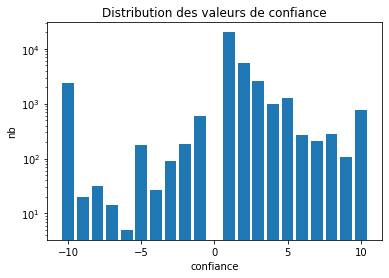

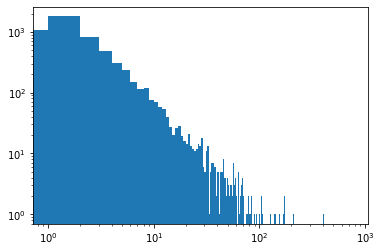

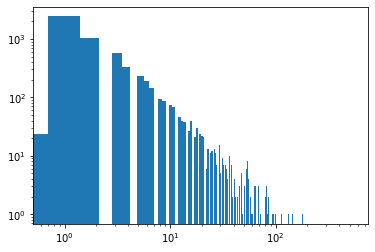

In [58]:
index = 1
data =load_data(index)
scores = data["edges"][:,2]
tab_scores = np.zeros(21)
for s in scores:
    tab_scores[10+s] += 1

plt.bar(np.arange(-10,11),tab_scores)
plt.yscale("log")
plt.title("Distribution des valeurs de confiance")
plt.ylabel("nb")
plt.xlabel("confiance")
plt.show()

plt.hist(data["out"],bins=int(np.max(data["out"])))
plt.xscale("log")
plt.yscale("log")
plt.show()

plt.hist(data["in"],bins=int(np.max(data["out"])))
plt.xscale("log")
plt.yscale("log")
plt.show()
